In [2]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver

### Query Device Properties

In [ ]:
DEVICE = torch.device('cuda:0')

In [49]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
print(f"{properties=}")
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

properties={'max_shared_mem': 101376, 'max_num_regs': 65536, 'multiprocessor_count': 64, 'warpSize': 32, 'sm_clock_rate': 1695000, 'mem_clock_rate': 8001000, 'mem_bus_width': 384}


### Softmax Kernel
Number of programs are calculated as: `NUM_SM * occupancy`. Occupancy is the ratio of Total available registers and the register usage per block:

`occupancy = NUM_REGS // (n_regs * num_warps * WARP_SIZE)`.
Number of programs represent the overall number of blocks as in Triton each program operates on a block of array, which makes occupancy the number of blocks per SM.

In [ ]:
@triton.jit
def softmax_kernel(input_ptr: torch.Tensor, output_ptr: torch.Tensor, 
            input_row_stride: int, output_row_stride: int, 
            num_rows: int, num_cols: int, BLOCK_SIZE: tl.constexpr,
            num_stages: tl.constexpr): 
    
    # Get the program id
    row_start = tl.program_id(0)
    # Get total number of programs
    row_step = tl.num_programs(0)
    
    # each program will handle num_rows // tl.num_programs(0) rows.
    # If num_rows = 2304, occupancy is 9 and NUM_SM = 64 => num_programs = 576
    # then each program would be responsible for doing 4 rows worth of work
    for row_idx in tl.range(row_start, num_rows, row_step, num_stages=num_stages):
        # standard way to index the array
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # get column offsets
        col_offsets = tl.arange(0, BLOCK_SIZE)
        # we have all the input pointers
        input_ptrs = row_start_ptr + col_offsets
        # get mask
        mask = col_offsets < num_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        row_minus_max = row - tl.max(row, axis=0)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # only difference here is that we use output_row_stride
        output_ptrs = output_ptr + row_idx * output_row_stride + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)
        
        
        

In [ ]:
def softmax(x: torch.Tensor):
    
    n_rows, n_cols = x.shape # Shape: N, D

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)
    # if warp size is 32, we'll have a total of 256 threads per block.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    # this is useful in calculating number of blocks per SM.
    kernel = softmax_kernel.warmup(x, y, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy
    print(f"{NUM_REGS=}, {occupancy=}, {size_smem=}, {n_regs=}, {num_programs=}, {NUM_SM=}, {size_smem=}, {SIZE_SMEM=}")
    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](x, y, x.stride(0), y.stride(0), n_rows, n_cols)
    return y, kernel

### Test the code
Reference implementation is `torch.softmax`

In [50]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton, kernel = softmax(x)
y_torch = torch.softmax(x, axis=-1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

NUM_REGS=65536, occupancy=9, size_smem=4128, n_regs=26, num_programs=576, NUM_SM=64, size_smem=4128, SIZE_SMEM=101376


### Benchmarking
Benchmarking code from: https://triton-lang.org/main/getting-started/tutorials/02-fused-softmax.html

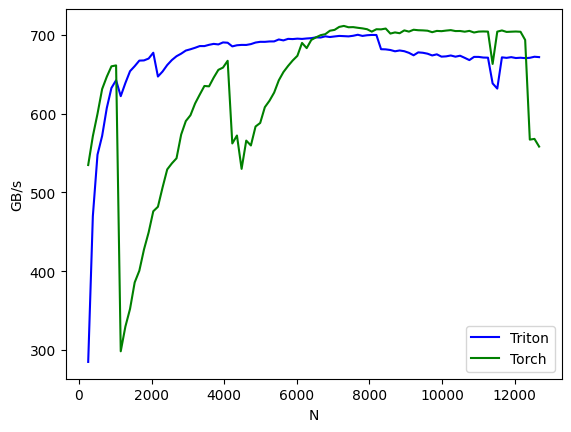

softmax-performance:
          N      Triton       Torch
0     256.0  284.944893  534.858198
1     384.0  469.966691  571.449986
2     512.0  547.980530  599.810881
3     640.0  571.850172  631.319805
4     768.0  607.245584  646.942746
5     896.0  632.654061  660.132102
6    1024.0  642.481676  661.291137
7    1152.0  622.272773  298.432614
8    1280.0  638.937442  329.810909
9    1408.0  653.967483  352.242916
10   1536.0  660.328679  385.841149
11   1664.0  667.398301  400.719870
12   1792.0  667.639273  427.676583
13   1920.0  670.007558  449.316303
14   2048.0  677.384343  476.162091
15   2176.0  647.168284  481.863932
16   2304.0  653.552057  506.435823
17   2432.0  661.780210  529.311851
18   2560.0  668.112141  536.944394
19   2688.0  672.954645  543.415511
20   2816.0  676.219262  573.538411
21   2944.0  680.153752  590.646390
22   3072.0  681.797000  598.049424
23   3200.0  683.692778  613.017976
24   3328.0  685.846658  624.303793
25   3456.0  685.818814  635.187207
26   35

In [33]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

For sufficiently large N, both the kernels end up achieving a throughput of 600-700 GBps, which is near the peak memory bandwidth of A5000. We see from the properties above that memory clock cycle is `8001000 kHz = 8 x 10^9 GHz` and `memory bust width = 384` which implies that the memory bandwidth (in Gbps) = ` clock rate * 2 * num_pins` = `8 * 10^9 * 2 * 384 = 6144 Gbps = 768 GBps`

One might ask why the multiplication with `2`?
The reason for that is that the clock is double pumped, data is transferred at the rising and falling edges of the clock cycle. If the memory clock is f Hz then the effective data rate is 2f transfers per second. 